In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

In [21]:
models = ['train', 'test', 'independent', 'ncov', 'nskewfcov']

In [4]:
model = 'nskewfcov'
matrix = load_matrix('data/Humannozf_{model}_k9_matrix.csv.gz'.format(model=model))
N, k = matrix.shape

# Fast? nearest neighbor calculation using scikit learn routines

In [5]:
bt = BallTree(matrix[:500000, :], metric='hamming')

In [6]:
dists = (bt.query(matrix[500000:501000, :], return_distance=True)[0]*9).flatten()

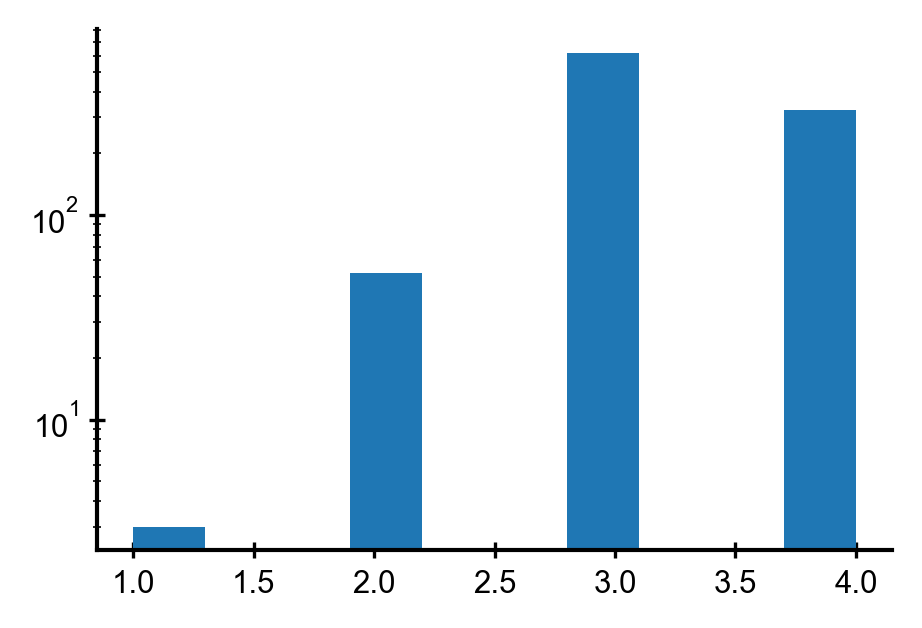

In [7]:
plt.hist(dists)
plt.yscale('log')

In [8]:
# use spotify annoy? https://github.com/spotify/annoy

# Fast nearest neighbor routines by neighbor set membership

In [9]:
def distance_distribution(sample, selfset):
    d0 = np.array([x in selfset for x in sample])
    count0 = np.sum(d0)
    d1 = np.array([dist1(x, selfset) for x in sample]) & (~d0)
    count1 = np.sum(d1)
    d2 = np.array([dist2(x, selfset) for x in sample]) & (~d1) & (~d0)
    count2 = np.sum(d2)
    ns = np.array([count0, count1, count2, len(sample)-count0-count1-count2])
    return ns

In [39]:
proteome = 'Humannozf'
kmers_dict = {}
for model in models:
    matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome, model=model))
    print(model, matrix.shape)
    kmers = matrix_to_kmers(matrix)
    kmers_dict[model] = kmers

train (5421876, 9)
test (5367489, 9)
independent (5421876, 9)
ncov (5421866, 9)
nskewfcov (5421866, 9)


In [40]:
distances = {}
for model in models:
    kmers = kmers_dict[model]
    sample = set(np.random.choice(kmers, 10000))
    distance = distance_distribution(sample, set(kmers_dict['test'])-sample)
    distances[model] = distance

model = 'train'
matrix = load_matrix('data/Humannozf_{model}_k9_matrix.csv.gz'.format(model=model))
kmers = matrix_to_kmers(matrix)
sample = np.random.choice(kmers, 5000)
for s in sample:
    kmers.remove(s)
distance = distance_distribution(sample, set(kmers))
distance

In [41]:
proteome = 'Humanviruses'
model = 'test'
matrix = load_matrix('data/{proteome}_{model}_k9_matrix.csv.gz'.format(proteome=proteome,
                                                                       model=model))
print(model, matrix.shape)
kmers = matrix_to_kmers(matrix)

test (543879, 9)


In [42]:
sample = set(np.random.choice(kmers, 10000))
distance_virus = distance_distribution(sample, set(kmers_dict['test'])-sample)

In [43]:
distance_virus, distances['train']

(array([   0,  166, 3202, 6527]), array([   0,  881, 3804, 5302]))

In [44]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

In [45]:
len(kmers_dict['test'])

5367489

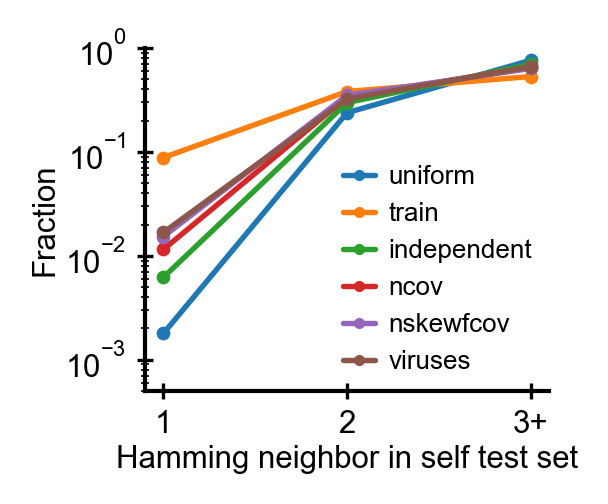

In [50]:
fig, ax = plt.subplots(figsize=(2.0, 1.75))
N = len(kmers_dict['test'])
d, p = nndist_probability(k, N)
ax.plot(d[1:4], [p[1], p[2], np.sum(p[3:])], '-o', label='uniform')

for model, distance in distances.items():
    if model in ['nskew', 'test']:
        continue
    ax.plot(range(1, 4), distance[1:]/np.sum(distance[1:]), '-o', label=model)
ax.plot(range(1, 4), distance_virus[1:]/np.sum(distance_virus[1:]), '-o', label='viruses')

ax.set_ylim(5e-4, 1)
ax.set_xticks(range(1, 4))
ax.set_xticklabels(['1', '2', '3+'])
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Fraction')
ax.set_xlabel('Hamming neighbor in self test set')
fig.tight_layout()

In [71]:
for model, distance in distances.items():
    print(model, distance[1:]/np.sum(distance[1:]))

train [0.09868882 0.38664798 0.5146632 ]
independent [0.00830498 0.33289974 0.65879528]
ncov [0.01150921 0.35278223 0.63570857]
nskew [0.00323265 0.07061319 0.92615416]
nskewfcov [0.01841289 0.3658561  0.61573101]
